## 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

### Domain Libraries
Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources**
* Book version for course materials for 04: on learnpytorch.io
* Ground truth version of notebook 04: on github

In [2]:
import torch
from torch import nn

# pytorch 1.10.0+ is required for this course
torch.__version__

'2.1.1'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 1. Get Data

Our dataset is a subset of the Food101 dataset

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images(~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary. 

The whole point is to speed up how fast you experiment.

In [4]:
import requests # to request something from github
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("./data")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    ##IMPORTANT! Download from the download button not the top URL address (download button uses "raw", top URL uses "blob")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip") 
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, and sushi data...")
    zip_ref.extractall(image_path) 

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak, and sushi data...


In [5]:
data_path / "pizza_steak_sushi.zip"

PosixPath('data/pizza_steak_sushi.zip')

### 2. Becoming one with the data (data prep and data exploration)

In [6]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're  working with (`Image.open()` fails when picture is corrupt - can use for data cleaning)
5. We'll then show the image and print metadata

In [9]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/test/sushi/2276986.jpg
Image class: sushi
Image height: 512
Image width 512


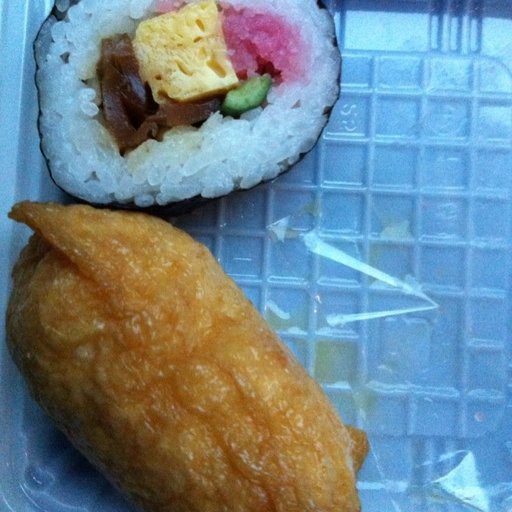

In [10]:
import random 
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the dir where image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path) # error when corrupt; can use to clean up data when corrupt

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width {img.width}")
img

#### Try to visualize an image with matplotlib...

(-0.5, 511.5, 511.5, -0.5)

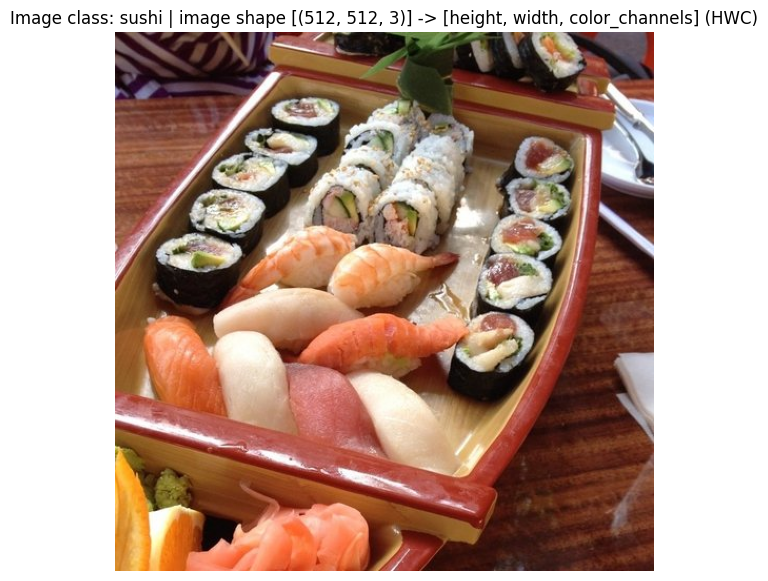

In [222]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))

img_path = random.choice(image_path_list)
# display image
img = Image.open(img_path)
plt.imshow(img)

# text showing metadata
img_class = img_path.parent.stem
img_as_array = np.asarray(img)
plt.title(f"Image class: {img_class} | image shape [{img_as_array.shape}] -> [height, width, color_channels] (HWC)")
plt.axis('off')

In [12]:
img_as_array

array([[[34,  8, 11],
        [33,  7, 10],
        [33,  7, 10],
        ...,
        [34,  4,  2],
        [35,  4,  2],
        [36,  5,  3]],

       [[33,  7, 10],
        [33,  7, 10],
        [33,  7, 10],
        ...,
        [34,  4,  2],
        [35,  4,  2],
        [36,  5,  3]],

       [[33,  7, 10],
        [33,  7, 10],
        [33,  7, 10],
        ...,
        [34,  4,  2],
        [35,  4,  2],
        [36,  5,  3]],

       ...,

       [[34,  4,  4],
        [35,  5,  5],
        [35,  7,  6],
        ...,
        [10,  5,  2],
        [10,  5,  2],
        [10,  5,  2]],

       [[34,  4,  4],
        [35,  5,  5],
        [35,  7,  6],
        ...,
        [10,  5,  2],
        [10,  5,  2],
        [10,  5,  2]],

       [[34,  4,  4],
        [35,  5,  5],
        [35,  7,  6],
        ...,
        [10,  5,  2],
        [10,  5,  2],
        [ 9,  4,  1]]], dtype=uint8)

### 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transforming data with `torchvision.transforms`
Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

Note: we can decrease the size of the image to allow our model to work faster

In [14]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images  randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [15]:
type(img)
img_transformed = data_transform(img)
img_transformed.shape

torch.Size([3, 64, 64])

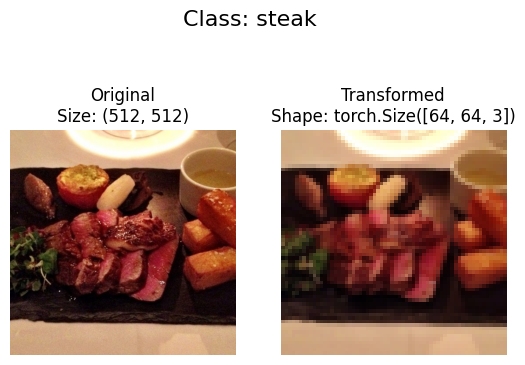

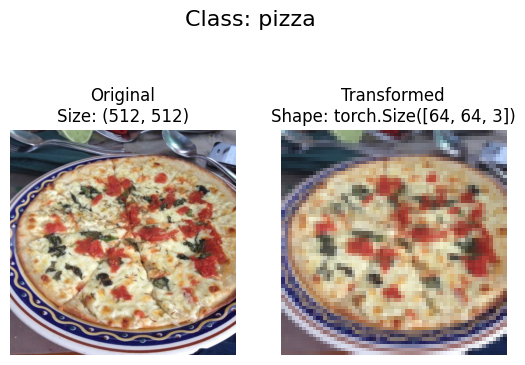

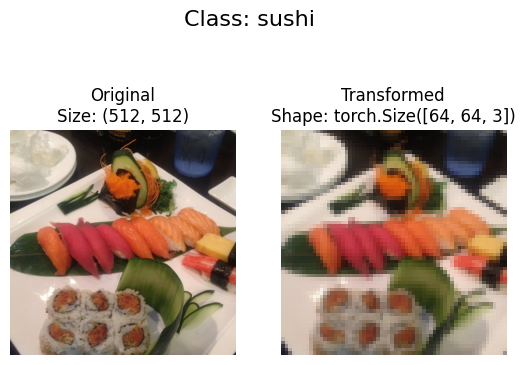

In [56]:
def plot_transformed_images(image_paths:list, transform, n = 3, seed = None):
    """
    Selects the random images from a path of images and loads/transforms
    them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, 
                        transform = data_transform, 
                        n=3,
                        seed=None)

### 4. Option 1: Loading image data using `ImageFolder`
We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [17]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform = None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
# Check the lengtsh of our dataset
len(train_data), len(test_data)

(225, 75)

In [21]:
train_data.targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [22]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [23]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

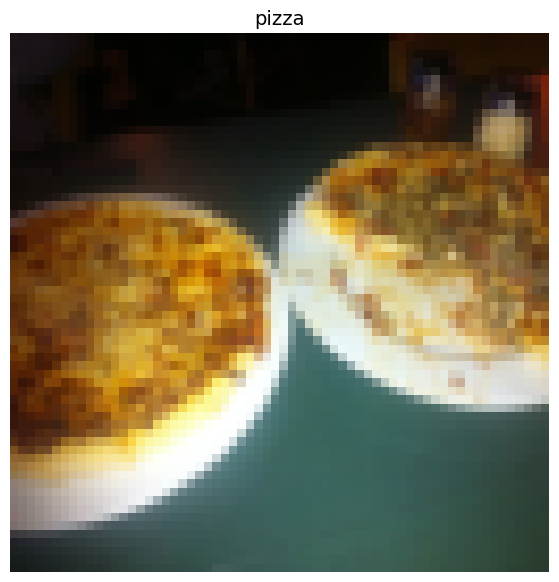

In [24]:
# Rearrange order of dimensions (color channels last)
img_permute = img.permute(1,2,0)

# Prin out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)


### 4.1 Turn  loaded images into `DataLoaders`

A `DataLoader` is going to help us turn our `Dataset`'s into iterabels and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [25]:
import os
os.cpu_count()

8

In [26]:
# Turn train and test datasets into Dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, 
                              batch_size = BATCH_SIZE, 
                              num_workers = 1,
                              shuffle = True)
test_dataloader = DataLoader(test_data, 
                             batch_size = BATCH_SIZE, 
                             num_workers = 1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x168c7fbd0>,
 <torch.utils.data.dataloader.DataLoader at 0x1689ba4d0>)

In [27]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [28]:
len(train_data), len(test_data)

(225, 75)

In [29]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


### 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
*  Using a custom `Dataset` often results  in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass `torch.utils.data.Dataset`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [30]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [31]:
#  Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [32]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target direcotyr
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [33]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [34]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""
    #1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    #2.  Raise error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
    
    #3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in  enumerate(classes)}

    return classes, class_to_idx

In [35]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.2 reate a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target diretory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd liek to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Oerwrite the `__getitem()__` method to return a given sample when passed an index

In [36]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. initialize our custom dataste
    def __init__(self, 
                 targ_dir:str, 
                 transform=None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg')) # order is arbitrary
        # Setup transforms
        self.transforms = transform
        # Classes 
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)       
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        #Transform if necessary
        if self.transforms:
            return self.transforms(img), class_idx # return data, label (X,y)
        else:
            totensor = transforms.Compose([transforms.ToTensor()])
            img_tensor = totensor(img)
            return img_tensor, class_idx # return untransformed image and label

In [37]:
# Create a trasnform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [38]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [39]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x168b97c90>,
 <__main__.ImageFolderCustom at 0x16897fbd0>)

In [40]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [41]:
len(train_data_custom), len(train_data)

(225, 225)

In [42]:
len(test_data_custom), len(test_data)

(75, 75)

In [43]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==train_data.classes)

print(train_data_custom.class_to_idx==train_data.class_to_idx)
print(test_data_custom.class_to_idx==train_data.class_to_idx)

True
True
True
True


In [44]:
# output looks good; not equal since .glob() returns files in arbitrary order
train_data.__getitem__(1)
train_data_custom.__getitem__(1)

(tensor([[[0.6314, 0.8314, 0.9294,  ..., 0.1137, 0.1020, 0.0941],
          [0.6000, 0.8118, 0.9294,  ..., 0.1176, 0.1059, 0.0980],
          [0.5686, 0.7804, 0.9412,  ..., 0.1176, 0.1020, 0.0941],
          ...,
          [0.8275, 0.8039, 0.8196,  ..., 0.8275, 0.8235, 0.8157],
          [0.8039, 0.8118, 0.8157,  ..., 0.8235, 0.8157, 0.8039],
          [0.7647, 0.8196, 0.8078,  ..., 0.8157, 0.8039, 0.7922]],
 
         [[0.5843, 0.8392, 0.9490,  ..., 0.1059, 0.0980, 0.0902],
          [0.5686, 0.8235, 0.9569,  ..., 0.1098, 0.1020, 0.0941],
          [0.5569, 0.7961, 0.9647,  ..., 0.1137, 0.0980, 0.0902],
          ...,
          [0.8667, 0.8431, 0.8588,  ..., 0.8784, 0.8667, 0.8549],
          [0.8431, 0.8549, 0.8549,  ..., 0.8745, 0.8588, 0.8471],
          [0.8039, 0.8627, 0.8549,  ..., 0.8667, 0.8510, 0.8392]],
 
         [[0.5765, 0.8667, 0.9725,  ..., 0.0902, 0.0824, 0.0745],
          [0.5725, 0.8510, 0.9765,  ..., 0.0941, 0.0863, 0.0784],
          [0.5647, 0.8314, 0.9843,  ...,

#### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot. 
6. Loop throguh the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)


In [45]:
import random
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n=10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting n = 10, and removing shape display.")

    # 3. set the seed
    if seed:
        random.seed(seed)
    
    # 4. Get random sample indexes
    random_sample_idx = random.sample(population=range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))

    # 6. Loop through matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0)

        # plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape :
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

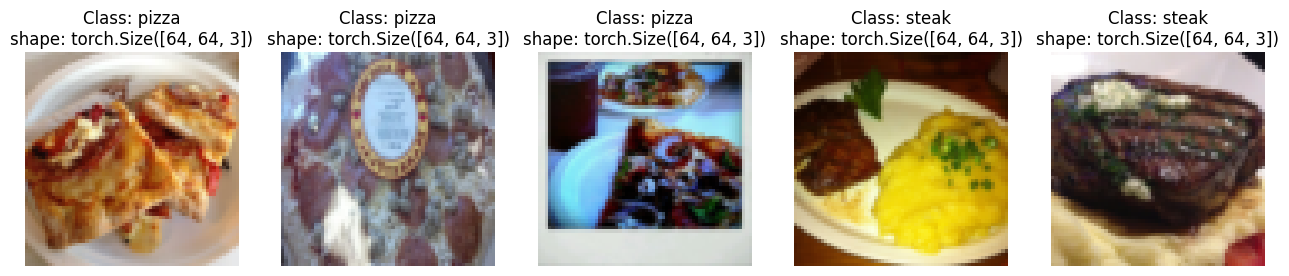

In [46]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes = class_names,
                      seed=None)

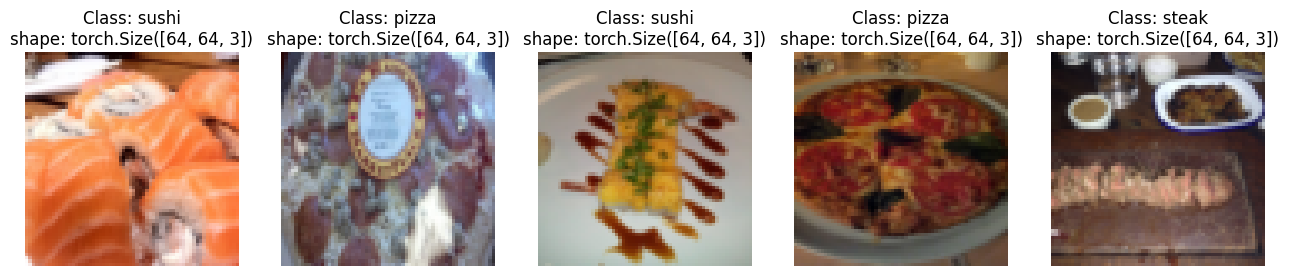

In [47]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

#### 5.4 Turn custom loaded images into `DataLoader`'s

In [48]:
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS=0
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS, # default is 0
                              shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x16910c290>,
 <torch.utils.data.dataloader.DataLoader at 0x1691cce10>)

In [49]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [50]:
iter(train_dataloader_custom) # may crash if numworkers > 0

### 6. Other forms of transforms

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results  in a model that is more generalizable to unseen data.

Let's take a look  at one particular type of data augmentation used to train PyTorch vision models ot state of the art levels... https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [51]:
# Let's look at trivialaugment
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # default is 31; this randomly picks an intensity with value 0-31 at which a random data augmentation is performed.
    transforms.ToTensor()
])

test_trasnform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [52]:
image_path

PosixPath('data/pizza_steak_sushi')

In [53]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

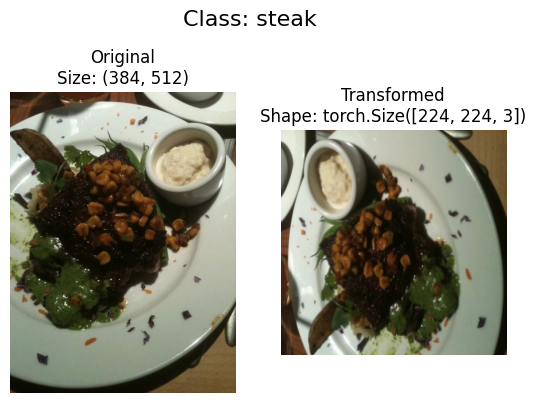

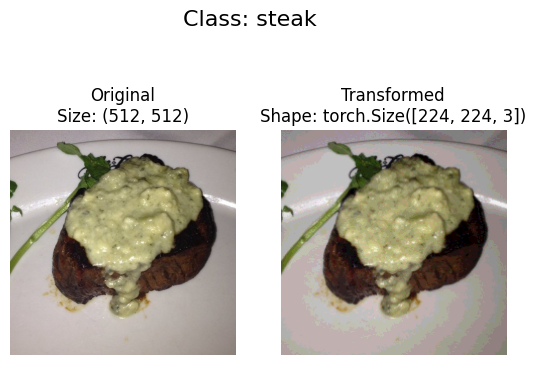

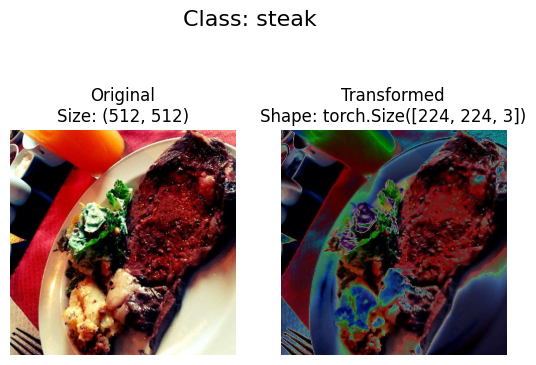

In [57]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

### 7. Model 0: TinyVGG without data augmentation

Let;s replicate the TinyVGG architecture from the CNN Explainer webstie: https://poloclub.github.io/cnn-explainer/

#### 7.1 Creating transforms and loading data for Model 0

In [62]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [63]:
# 1. load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and num workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()//2

# Create Dataloader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

#### 7.2 Create Tiny VGG model class

In [85]:
from torch import nn

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN explainer
    """
    def __init__(self, input_shape:int, output_shape:int, hidden_units:int) -> None:
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2,
                         stride=2)                       
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2,
                         stride=2)    
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, # * x * x
                      out_features=output_shape)
        )

    def forward(self,x):
        #x = self.block1(x)
        #print(x.shape)
        #x = self.block2(x)
        #print(x.shape)
        #x = self.classifier(x) # should throw error before fixing this method
        #print(x.shape)
        #return x
        return self.classifier(self.block2(self.block1(x))) # is faster through "operator fusion"

In [86]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10, # same number as TinyVGG
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

#### 7.3 Try a forward pass on a single image (to test the model)

In [79]:
# get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [87]:
# Try a forward pass
model_0(image_batch) # inner dimensions need to be equal for matrix multiplication

tensor([[ 2.0996e-02,  1.6418e-04,  1.2481e-02],
        [ 2.2141e-02, -2.4331e-03,  9.7279e-03],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2015e-02, -1.4427e-03,  7.8838e-03],
        [ 1.8531e-02, -1.0000e-04,  8.0369e-03],
        [ 1.9419e-02, -1.3767e-03,  1.1126e-02],
        [ 2.0323e-02, -1.7798e-03,  7.8779e-03],
        [ 1.9683e-02, -5.2765e-03,  9.3057e-03],
        [ 2.0531e-02, -3.9331e-03,  1.0121e-02],
        [ 2.2621e-02, -2.8323e-03,  1.1813e-02],
        [ 2.0226e-02,  4.4109e-04,  1.0933e-02],
        [ 2.0046e-02,  4.5708e-04,  1.0549e-02],
        [ 2.0669e-02,  2.8662e-03,  7.6834e-03],
        [ 2.1628e-02, -6.8519e-05,  9.2268e-03],
        [ 1.8115e-02, -1.2470e-04,  1.0741e-02],
        [ 1.9423e-02, -3.4742e-03,  1.1606e-02],
        [ 2.0772e-02,  1.3448e-03,  9.7040e-03],
        [ 2.0510e-02, -7.8608e-04,  8.4659e-03],
        [ 1.9368e-02, -7.8521e-04,  1.0480e-02],
        [ 2.3170e-02, -1.5725e-03,  8.5610e-03],
        [ 2.0672e-02

#### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [95]:
try:
    import torchinfo
except:
    %pip install torchinfo
    import torchinfo
from torchinfo import summary

MODEL = model_0
BATCH_SIZE = 1
summary(MODEL, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

#### 7.5 Create train and test loop functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [105]:
# Create a train step
def train_step(model:nn.Module, 
               dataloader:torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    model.train()

    train_loss, train_acc = 0,0

    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        # forward pass
        y_pred = model(X)

        # calculate loss
        loss = loss_fn(y_pred, y)

        train_loss += loss.item()

        # optimizer zero grad
        optimizer.zero_grad()

        # backward loss
        loss.backward()

        # optimizer step
        optimizer.step()

        # accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) # softmax not necessary
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [108]:
# Create a test step
def test_step(model:nn.Module, 
              dataloader:torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device=device):
    model.eval()
    
    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            # forward pass
            y_pred_logits = model(X)

            # calculate loss, accuracy
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item() # .item() gives you a single average loss across the batches; otherwise loss will give you multiple values which you must manually average

            test_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1) # softmax not necessary 
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
    
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

#### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [102]:
# Create training-testing loop
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model:nn.Module,
          train_dataloader:torch.utils.data.DataLoader,          
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:nn.Module,
          epochs: int = 5,
          device = device
          ):
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model,train_dataloader,loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model,test_dataloader, loss_fn, device)

        # 4. Print out what's happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epocsh
    return results

/Users/amyfan/Desktop/pytorch-walkthrough/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 7.7 Train and evaluate model 0

In [109]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

#  Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer function
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:38<02:34, 38.65s/it]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0985 | Test acc: 0.2604


 40%|████      | 2/5 [01:17<01:56, 38.67s/it]

Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417


 60%|██████    | 3/5 [01:55<01:17, 38.66s/it]

Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924


 80%|████████  | 4/5 [02:34<00:38, 38.61s/it]

Epoch: 3 | Train loss: 1.0844 | Train acc: 0.3984 | Test loss: 1.0614 | Test acc: 0.5833


100%|██████████| 5/5 [03:13<00:00, 38.65s/it]

Epoch: 4 | Train loss: 1.0663 | Train acc: 0.4141 | Test loss: 1.0649 | Test acc: 0.5644
Total training time: 193.229 seconds


In [110]:
model_0_results

{'train_loss': [1.1063195765018463,
  1.0998011529445648,
  1.0868771374225616,
  1.0843935459852219,
  1.0662527233362198],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0985397895177205,
  1.0696784257888794,
  1.0807685852050781,
  1.0613709688186646,
  1.0648931662241619],
 'test_acc': [0.2604166666666667,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

#### 7.8 Plot the loss curves of Model 0
A **loss curve** is a way of tracking your model's progress over time

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [111]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [112]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots traning curves of a results dictionary."""
    # Get the loss values of the results dictionary([training and test])
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    #  Figures out how many epoches there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15,7))

    # Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label = "train_accuracy")
    plt.plot(epochs, test_accuracy, label = "test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

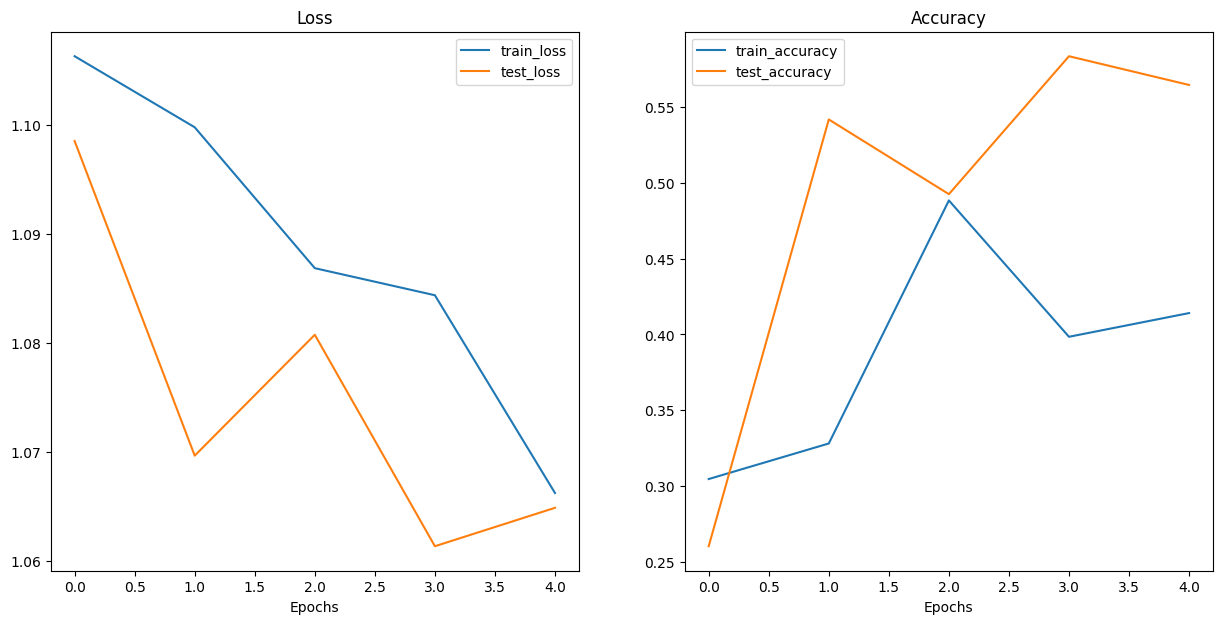

In [113]:
plot_loss_curves(model_0_results) # underfitting problem

### 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to  troubleshoot a model.

### 9. TinyVGG with data augmentation

Now let's try another modeling experiment this time using the same model as before with some data augmentation.

#### 9.1 Create transform with data augmentation

In [115]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

#### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [116]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                            transform=test_transform_simple)


In [118]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() // 2

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

#### 9.3 Construct and train model 1 

This time we'll be using the same model architecture except this time we've augmented the training data

In [123]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  output_shape=len(train_data_augmented.classes),
                  hidden_units=10).to(device)

In [122]:
# Set random seed
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = 0.001)

# Start timer
from timeit import default_timer as timer

start_time = timer()
model_1_results = train(
    model=model_1, 
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_simple,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS, 
    device = device)
end_time = timer()

print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

 20%|██        | 1/5 [00:38<02:35, 38.89s/it]

Epoch: 0 | Train loss: 1.1048 | Train acc: 0.2500 | Test loss: 1.1014 | Test acc: 0.2604


 40%|████      | 2/5 [01:17<01:56, 38.80s/it]

Epoch: 1 | Train loss: 1.0773 | Train acc: 0.4258 | Test loss: 1.1293 | Test acc: 0.2604


 60%|██████    | 3/5 [01:56<01:17, 38.77s/it]

Epoch: 2 | Train loss: 1.0760 | Train acc: 0.4258 | Test loss: 1.1658 | Test acc: 0.2604


 80%|████████  | 4/5 [02:35<00:39, 39.04s/it]

Epoch: 3 | Train loss: 1.1243 | Train acc: 0.3047 | Test loss: 1.1523 | Test acc: 0.2604


100%|██████████| 5/5 [03:14<00:00, 38.91s/it]

Epoch: 4 | Train loss: 1.0808 | Train acc: 0.4531 | Test loss: 1.1489 | Test acc: 0.3125
Total training time for model_1: 194.556 seconds


#### 9.4 Plot the loss curves of model 1

A loss curve helps you evaluate your model performance overtime.

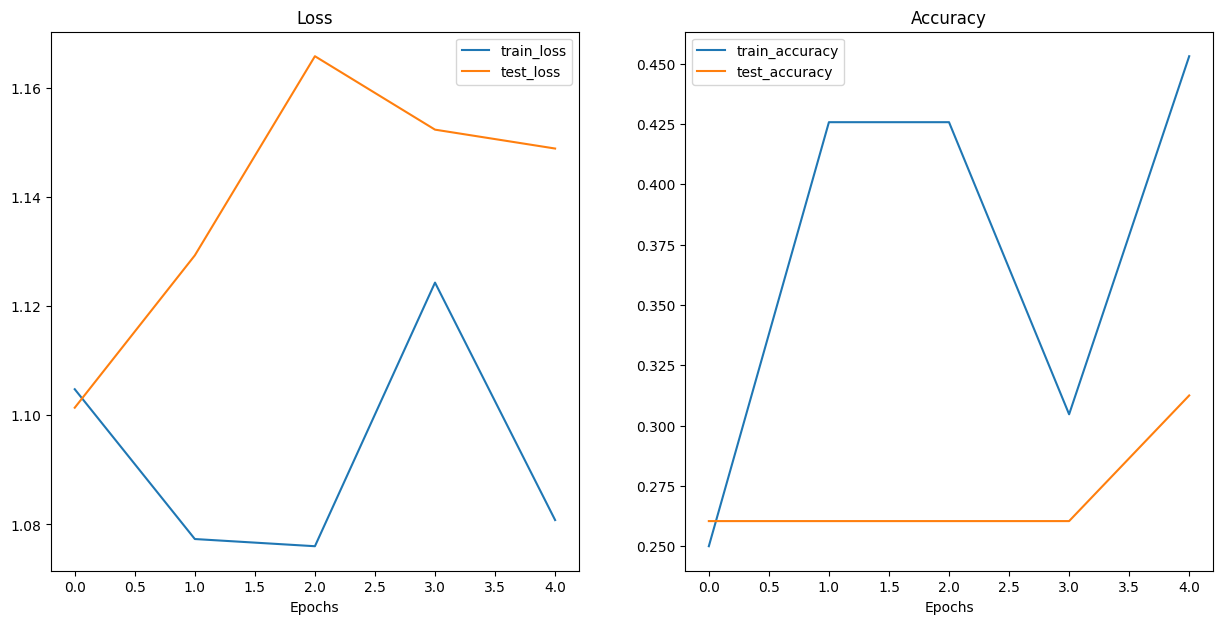

In [124]:
plot_loss_curves(results=model_1_results) # makes sense  since dataaugmentation is used for overfitting not underfitting

#### NOTE: How to deal with over-/underfitting
overfitting: https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting

underfitting: https://www.learnpytorch.io/04_pytorch_custom_datasets/#82-how-to-deal-with-underfitting

### 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + tensorboard: https://pytorch.org/docs/stable/tensorboard.html
3. Weights and biases: https://wandb.ai/site
4. MLFlow: https://mlflow.org/

In [127]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd. DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106320,0.304688,1.098540,0.260417
1,1.099801,0.328125,1.069678,0.541667
2,1.086877,0.488281,1.080769,0.492424
3,1.084394,0.398438,1.061371,0.583333
4,1.066253,0.414062,1.064893,0.564394


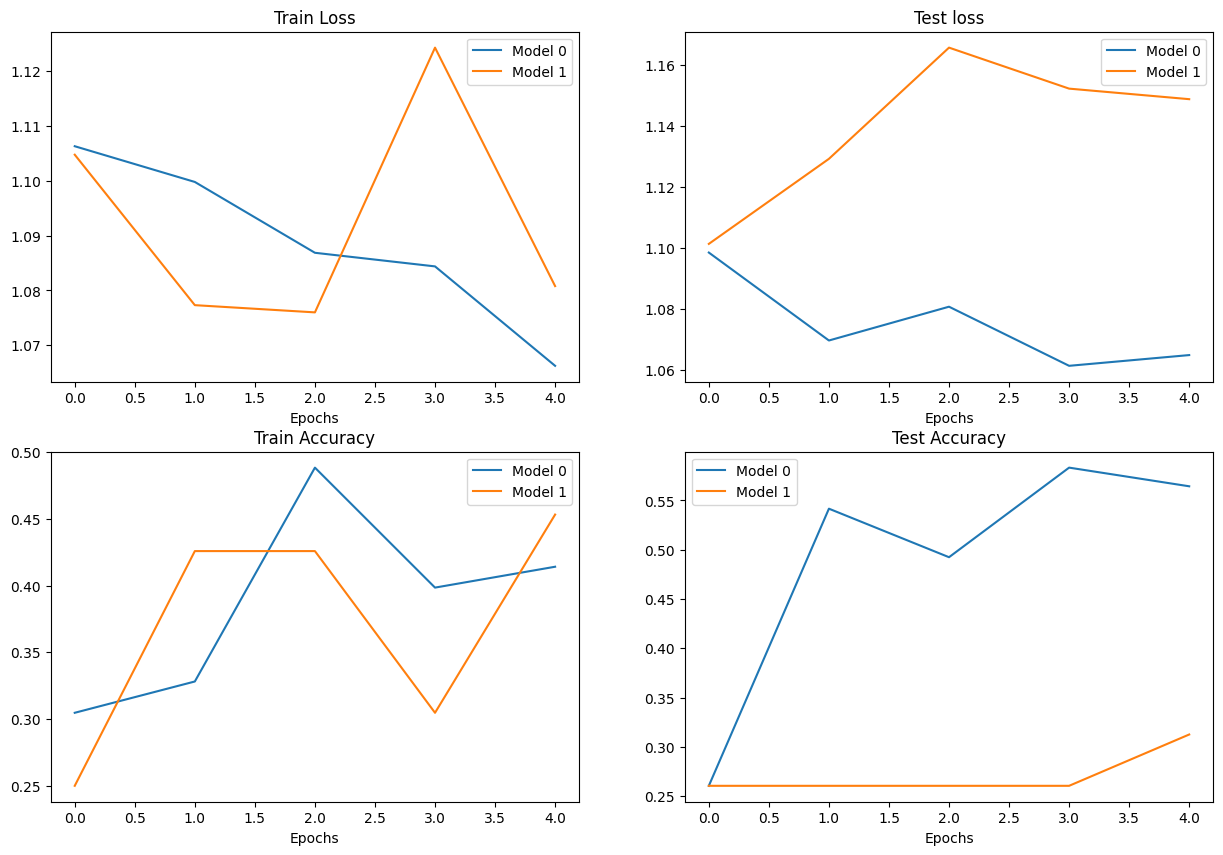

In [132]:
# Setup a plot
plt.figure(figsize=((15,10)))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

### 11. Maknig a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.


In [174]:
# Download a custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link format - https://raw.githubusercontent.com/user/path_to_file (doesn't contain "blob")
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download...")

data/04-pizza-dad.jpeg already exists, skipping download...


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [175]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape:\n {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape:
 torch.Size([3, 4032, 3024])
Custom image dat

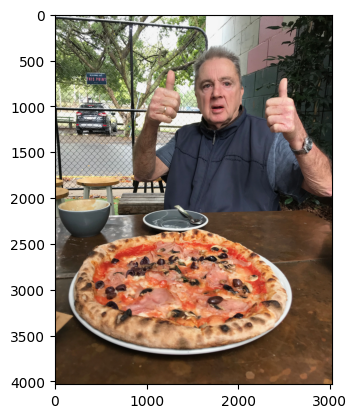

In [149]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [ ]:
#### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [176]:
from torchvision.transforms import v2

custom_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    v2.ToDtype(torch.float32, scale = True)
])

transformed_custom_img = custom_transform(custom_image_uint8)

# Print out the shape
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {transformed_custom_img.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


/Users/amyfan/Desktop/pytorch-walkthrough/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


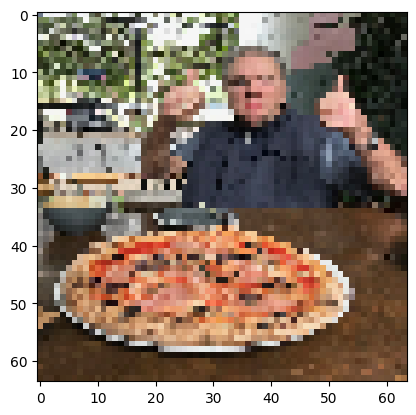

In [159]:
plt.imshow(transformed_custom_img.permute(1,2,0))

In [161]:
# Try to make a prediction on an image in uint8 format
# This will error: wrong dtype
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [168]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255. # /255 to scale
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

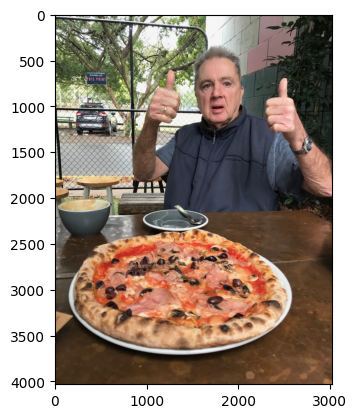

In [169]:
plt.imshow(custom_image.permute(1,2,0)) # now float32

In [181]:
# This will error: wrong size of original (need resize to 64x64)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [180]:
transformed_custom_img.shape, transformed_custom_img.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [197]:
# let's use our transformed image
# This will work (added batch size)
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(transformed_custom_img.unsqueeze(0).to(device))

custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
print(f"Prediction probabilities: {custom_image_pred_probs} basically as good as guessing")

custom_image_pred_label = custom_image_pred.argmax(1).cpu().item()
print(f"Model prediction: {class_names[custom_image_pred_label]}")

Prediction probabilities: tensor([[0.3376, 0.3302, 0.3322]]) basically as good as guessing
Model prediction: pizza


Note,  to make a prediction on a custom image we had to:
* Load the image and turn into a tensor
* Make sure the image was same dtype as model  (torch.float32)
* Make sure the data was the same shape  as the data the model trained on (3,64,64) with a batch size... (1,3,64,64)
* Make sure the image was on the same device as the model

#### 11.4 putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [217]:
import torchvision

def pred_and_plot(model: nn.Module, 
                  image_path:str, 
                  class_names: List[str] = None, 
                  transform = None,
                  device = device):
    """Makes a prediction on a target image with a trained model and plots the image and prediction."""
    # Load image and convert to float32
    target_image = torchvision.io.read_image(image_path).type(torch.float32)
    
    # Rescale to 0-1
    target_image = target_image / 255.

    # Transform if necessary
    if transform:
        target_image = transform(custom_image)
    
    # Send to device
    model.to(device)
    target_image = target_image.to(device)

    # make model prediction
    model.eval()
    with torch.inference_mode():
        # add extra batch dimension
        y_pred_logits = model(target_image.unsqueeze(0))
        y_pred_probs = torch.softmax(y_pred_logits, dim = 1)
        label = y_pred_probs.argmax(dim = 1) 

    # plot image with prediction as label (CPU only)
    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
        title = f"Pred: {class_names[label.cpu()]} | Prob: {y_pred_probs.max():.4f}"
    else:
        title = f"Pred: {label} | Prob: {y_pred_probs.max():.4f}"    
    plt.title(title)
    plt.axis('off')


/Users/amyfan/Desktop/pytorch-walkthrough/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


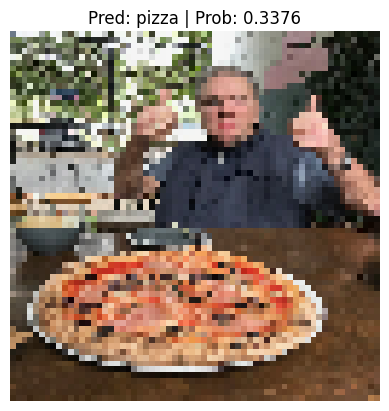

In [220]:
pred_and_plot(model=model_1, 
              image_path=str(custom_image_path), 
              class_names=class_names, 
              transform=custom_transform, 
              device="cpu")

In [221]:
# Exercise 4
with open("04_custom_datasets_exercises.ipynb", "wb") as f:
    ##IMPORTANT! Download from the download button not the top URL address (download button uses "raw", top URL uses "blob")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb") 
    f.write(request.content)